In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import reduce
import random

from keras.preprocessing.image import ImageDataGenerator
import keras 

from keras import regularizers
import keras.backend as K 

import tensorflow as tf
from keras.models import Model
from keras.layers import Lambda, UpSampling2D, \
            Flatten, Dense, Conv2D, MaxPooling2D, ZeroPadding2D,\
            AveragePooling2D

from keras.optimizers import Adam, SGD
from keras.applications import ResNet50, densenet

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

W0703 03:59:47.274782 140093553018624 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0703 03:59:47.276630 140093553018624 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0703 03:59:47.277559 140093553018624 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0703 03:59:50.509663 140093553018624 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
class Image_class:
    def __init__(self, pat_n, image, roi, n_serial):
        
        self.name = pat_n
        self.image = image
        self.roi = roi
        self.mal = False
        self.n_serial = n_serial
        
        if np.sum(roi) > 0:
            self.mal = True
        
    def print_roi(self, cmap = 'plasma', linewidths = 0.5,  **args):
        plt.contour(self.roi, cmap = cmap, linewidths = linewidths, **args)
            
    def print_image(self, cmap = 'gray', **args):
        plt.imshow(self.image, cmap = 'gray', **args)
 

In [3]:
def create_train_test_sets(poss, negs, admitted_pos, num_test = 50 ):
    negs.pop('Brats18_CBICA_AWI_1')
    poss.pop('Brats18_CBICA_AWI_1')
    
    poss_shuffled = list(poss.keys())
    random.shuffle(poss_shuffled)
    
    test_pts = poss_shuffled[ :num_test]
    train_pts = poss_shuffled[num_test:]
    
    files_pos_train = reduce(lambda x,y:x+y, [poss[x] for x in train_pts])
    files_neg_train = reduce(lambda x,y:x+y, [negs[x] for x in train_pts])

    files_pos_train = [x for x in files_pos_train if x in admitted_pos]
    random.shuffle(files_neg_train)
    
    files_train = files_pos_train + files_neg_train[:len(files_pos_train)]
    
    files_pos_test = reduce(lambda x,y:x+y, [poss[x] for x in test_pts])
    files_neg_test = reduce(lambda x,y:x+y, [negs[x] for x in test_pts])
    
    files_pos_test = [x for x in files_pos_test if x in admitted_pos]
    random.shuffle(files_neg_train)
    
    files_test = files_pos_test + files_neg_test[:len(files_pos_test)]
    
    
    random.shuffle(files_train)
    random.shuffle(files_test)
    
    return files_train, files_test
    

In [4]:
def downsample_map(image, dims_tr = (44, 36)):
    h, w = image.shape
    
    image_tr = np.zeros(dims_tr)
    for i in range(h):
        for j in range(w):
            if image[i,j] > 0:
                image_tr[int((i / h) // (1.0 / dims_tr[0])),
                     int((j / w) // (1.0 / dims_tr[1]))] = 1.0
            
    return image_tr

class DataGenerator_FS(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=16, dim=(170, 140), n_channels=3,
                  shuffle=True, OUT_SIZE = (44, 36), TOP_K = 1, mode = 'train'):
        'Initialization'
        
        self.dim = dim # ?-1
        self.OUT_SIZE = OUT_SIZE
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.TOP_K = TOP_K
        
        self.on_epoch_end()

        self.aug = ImageDataGenerator(rotation_range=45, width_shift_range=0.1,\
                                      height_shift_range=0.1, horizontal_flip=True)
        self.mode = mode

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # X : (n_samples, *dim, n_channels)

        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.OUT_SIZE), dtype='float32')
        

        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            
            with open('BRATS_preprocessed_/' + ID, 'rb') as filehandler:
                photo = pickle.load(filehandler)
                
            img = photo.image
            roi = photo.roi
            
            roi[roi > -1.0] = 1.0
            roi[roi == -1.0] = 0.0
            
            #print(np.min(roi), np.max(roi))
            
            XX = np.repeat(img.reshape(*self.dim, 1), 3, axis = 2)   
            yy = np.repeat(roi.reshape(*self.dim, 1), 3, axis = 2)
            
            if self.mode == 'train':
                params = self.aug.get_random_transform(XX.shape)
                X[i,] = self.aug.apply_transform(XX, params)
                
                
                if photo.mal: 
                    ROI_tr = self.aug.apply_transform(yy, params)
                    y[i,:] = downsample_map(ROI_tr[:,:,0], self.OUT_SIZE)
                else:
                    y[i,:] = np.zeros(self.OUT_SIZE)
                
                
            else:
                X[i,] = XX
                
                if photo.mal: 
                    y[i,:] = downsample_map(yy[:,:, 0], self.OUT_SIZE)
                else:
                    y[i,:] = np.zeros(self.OUT_SIZE)
            
              

        return X, y

In [5]:
class DataGenerator_WS(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=16, dim=(170, 140), n_channels=3,
                  shuffle=True, OUT_SIZE = 12, TOP_K = 4, mode = 'train'):
        'Initialization'
        
        self.dim = dim # ?-1
        self.OUT_SIZE = OUT_SIZE
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.TOP_K = TOP_K
        
        self.on_epoch_end()

        self.aug = ImageDataGenerator(rotation_range=45, width_shift_range=0.1,\
                                      height_shift_range=0.1, horizontal_flip=True)
        self.mode = mode

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # X : (n_samples, *dim, n_channels)

        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.OUT_SIZE), dtype='float32')
        

        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            
            with open('BRATS_preprocessed_/' + ID, 'rb') as filehandler:
                photo = pickle.load(filehandler)
                
            img = photo.image
            
            XX = np.repeat(img.reshape(*self.dim, 1), 3, axis = 2)   
            
            if self.mode == 'train':
                params = self.aug.get_random_transform(XX.shape)
                X[i,] = self.aug.apply_transform(XX, params)
            else:
                X[i,] = XX
            
            yy  = np.zeros(self.OUT_SIZE, dtype = 'float32')
            
            if photo.mal:
                #y[i,:] = np.array([1.0, 0.0])
                yy[:self.TOP_K] = 1.0
                y[i,:] = yy
            else:
                #y[i,:] = np.array([0.0, 1.0]) 
                y[i,:] = yy

        return X, y

In [6]:
from keras import backend as K
from keras.layers import Layer

class My_mul(Layer):

    def __init__(self, **kwargs):

        super(My_mul, self).__init__(**kwargs)

    def build(self, input_shape):

        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], 1),
                                      initializer='uniform',
                                      trainable=True)
        super(My_mul, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.tensordot(x, self.kernel, axes = [[-1],[0]])

    def compute_output_shape(self, input_shape):
        x,y,z,m = input_shape
        return (x,y,z,1)

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def custom_acc_mil(y_true, y_pred):
    return K.mean(K.equal(K.max(K.round(y_pred), axis = -1), K.max(y_true, axis = -1)))

def custom_loss_mil(y_true, y_pred):

    c1 = tf.clip_by_value(y_pred, 1e-15, 1.0 - 1e-15)
    v1 = tf.math.multiply(1.0 - y_true, tf.math.log(1.0 - c1))
    v2 = tf.math.multiply(y_true, tf.math.log(c1))

    return -tf.reduce_mean(tf.add(v1, v2))#keras.losses.binary_crossentropy


def custom_acc_fs(y_true, y_pred):
    return K.mean(K.equal(K.round(y_pred), y_true))

def custom_loss_fs(y_true, y_pred):

    c1 = tf.clip_by_value(y_pred, 1e-15, 1.0 - 1e-15)
    v1 = tf.math.multiply(1.0 - y_true, tf.math.log(1.0 - c1))
    v2 = tf.math.multiply(y_true, tf.math.log(c1))

    return -tf.reduce_mean(tf.add(v1, v2))#keras.losses.binary_crossentropy


def create_model(mm_, lambd_reg = 5e-6, learning_rate = 5e-5, mu_reg = 1e-3):
    

    inp = mm_.input
    
    c_6 = mm_.get_layer("res2c_branch2c")
    #c_6.activity_regularizer = regularizers.l1(lambd_reg)
    c_6 = ZeroPadding2D(padding=((1,0),(1,0)))(c_6.output)
    
    
    c_18 = mm_.get_layer("res3d_branch2c")
    #c_18.activity_regularizer = regularizers.l1(lambd_reg)
    c_18 = c_18.output
    
    c_42 = mm_.get_layer("res4f_branch2c")
    #c_42.activity_regularizer = regularizers.l1(lambd_reg)
    c_42 = c_42.output
    
    '''
    c_58 = mm_.get_layer("activation_49")
    #c_58.activity_regularizer = regularizers.l1(lambd_reg)
    c_58 = c_58.output
    '''

    def add(a):
        return tf.math.add(a[0], a[1])
    
    upsampling1 = UpSampling2D(size=(2, 2), data_format="channels_last", interpolation='bilinear')
    upsampling2 = UpSampling2D(size=(2, 2), data_format="channels_last", interpolation='bilinear')

    layer_4 = My_mul()(c_42)
    
    layer_3 = Lambda(add)([upsampling1(layer_4), My_mul()(c_18)])

    layer_2 = Lambda(add)([upsampling2(layer_3), My_mul()(c_6)])
    
    conv = Conv2D(1, (1,1), name = 'Conv_Sigmoid', 
    #              activity_regularizer = regularizers.l1(mu_reg),\
                  activation = 'sigmoid')(layer_2)
    
    #MIL#######################################
    pooled = MaxPooling2D(pool_size = (10,10),\
                              strides = 10, padding='valid')(conv)
  
    #pooled = MaxPooling2D(pool_size = (44,36),\
    #                          strides = 1, padding='valid')(conv)
  
    
    lda_mil = Lambda(lambda x: tf.contrib.framework.sort(Flatten()(x),\
        axis=-1, direction = 'DESCENDING'), name="Sort")
    
    #pool_max = MaxPooling2D(pool_size = (4,3),\
    #                          strides = 1, padding='valid')
    #out = Dense(2, activation = 'softmax')(lda(pooled))
    
    #print(pooled)
    out_mil = lda_mil(pooled) #pooled
    
    model_train_mil = Model(inputs = inp, outputs = out_mil)# out_mil
    ###################################################
    #FS###############################################
    lda_fs = Lambda(lambda x: K.squeeze(x, axis = -1))(conv)
    model_train_fs = Model(inputs = inp, outputs = lda_fs)
    
    for layer in model_train_mil.layers:
        layer.kernel_regularizer = regularizers.l2(lambd_reg)
        
    model_image = Model(inputs = inp, outputs = conv)
    
    adam_mil = Adam(learning_rate / 10.0)#SGD(lr = learning_rate / 100.0, momentum = 0.9, nesterov = True)#Adam(learning_rate / 100.0)
    adam_fs = Adam(learning_rate )#SGD(lr = learning_rate, momentum = 0.9, nesterov = True)#Adam(learning_rate)
    
    model_train_mil.compile(optimizer = adam_mil, loss = custom_loss_mil, metrics = [custom_acc_mil])
    model_train_fs.compile(optimizer = adam_fs, loss = custom_loss_fs, metrics = [custom_acc_fs, dice_coef_loss])
    
    #model_train.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model_train_mil, model_train_fs, model_image

In [8]:


with open('patients_pos', 'rb') as filehandler:
    patients_pos = pickle.load(filehandler)
    
with open('patients_neg', 'rb') as filehandler:
    patients_neg = pickle.load(filehandler)
    
with open('10_percent_lesions', 'rb') as filehandler:
    admitted_pos = pickle.load(filehandler)   
    
#train_namespace, val_namespace = create_train_test_sets(\
#                patients_pos, patients_neg, admitted_pos)

with open('Mass_experiment/experiment_1/train_namespace', 'rb') as filehandler:
    train_namespace = pickle.load(filehandler) 
    
with open('Mass_experiment/experiment_1/val_namespace', 'rb') as filehandler:
    val_namespace = pickle.load(filehandler)

N_fs = 100

train_namespace_fs = train_namespace[:N_fs]
train_namespace_mil = train_namespace[N_fs:]



In [ ]:
model = ResNet50(include_top=False, weights='imagenet', input_shape = (170, 140, 3))

model.load_weights('Train_Classifyer/model.hdf5')

In [ ]:
for i in range(11, 31):
    os.mkdir('Mass_experiment/experiment_' + str(i))

In [ ]:
model.save_weights('Mass_experiment/initial_weights.hdf5')
        

In [ ]:
model = ResNet50(include_top=False, weights='imagenet', input_shape = (170, 140, 3))

In [ ]:
mm_mil, mm_fs, mm_image = create_model(model)

training_generator_mil = DataGenerator_WS(train_namespace_mil, mode = 'train')
training_generator_fs = DataGenerator_FS(train_namespace_fs, mode = 'train')


validation_generator_mil = DataGenerator_WS(val_namespace, mode = 'val')
validation_generator_fs = DataGenerator_FS(val_namespace, mode = 'val')

In [ ]:
N_fs = 100
N_best_by_exp = 1

for experiment in [str(i) for i in range(1,31)]:
    
    if int(experiment) < 10:
        N_fs = 100
    elif int(experiment) < 20:
        N_fs = 500
    else:
        N_fs = 1000
    
    print("EXPERIMENT " + experiment + '\n\n')
    
    K.clear_session()
    model = ResNet50(include_top=False, weights='imagenet', input_shape = (170, 140, 3))
    #model.load_weights('Mass_experiment/initial_weights.hdf5')
    mm_mil, mm_fs, mm_image = create_model(model)
    
    with open('patients_pos', 'rb') as filehandler:
        patients_pos = pickle.load(filehandler)
    
    with open('patients_neg', 'rb') as filehandler:
        patients_neg = pickle.load(filehandler)
    
    with open('10_percent_lesions', 'rb') as filehandler:
        admitted_pos = pickle.load(filehandler) 
    
    
    train_namespace, val_namespace = create_train_test_sets(\
                        patients_pos, patients_neg, admitted_pos)

    train_namespace_fs = train_namespace[:N_fs]
    train_namespace_mil = train_namespace[N_fs:]
    
    
    training_generator_mil = DataGenerator_WS(train_namespace_mil, mode = 'train')
    training_generator_fs = DataGenerator_FS(train_namespace_fs, mode = 'train')


    validation_generator_mil = DataGenerator_WS(val_namespace, mode = 'val')
    validation_generator_fs = DataGenerator_FS(val_namespace, mode = 'val')
    
    
    filepath = 'Mass_experiment/experiment_' + experiment + \
        '/model-{epoch:02d}-{val_dice_coef_loss:.2f}.hdf5'
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    
    if int(experiment) % 10 > 7:
        K.set_value(mm_fs.optimizer.lr, 5e-7)
    elif int(experiment) % 10 > 4:
        K.set_value(mm_fs.optimizer.lr, 5e-6)
    else:
        K.set_value(mm_fs.optimizer.lr, 5e-5)
    
    history = mm_fs.fit_generator(generator=training_generator_fs,
            validation_data=validation_generator_fs,
            use_multiprocessing=True,
             callbacks=callbacks_list,
            workers=4, verbose = 1, epochs = 40)
    
    all_files = set(os.listdir('Mass_experiment/experiment_' + experiment))
    
    if '.ipynb_checkpoints' in all_files:
        all_files.remove('.ipynb_checkpoints') 
    
    all_files_dict = {int(x[6 : 7 + x[7:].find('-')]) : x for x in all_files}
    
    chosen_files = sorted(list(all_files_dict.keys()), reverse = True)[:N_best_by_exp]
    
    with open('Mass_experiment/experiment_' + experiment + '/history', 'wb') as filehandler:
        pickle.dump(history, filehandler)
        
    print('***********Fine Tuning************\n')
    
    for file in chosen_files:
        
        file_name = all_files_dict[file]
        
        K.clear_session()
        model = ResNet50(include_top=False, weights='imagenet', input_shape = (170, 140, 3))
        #model.load_weights('Mass_experiment/initial_weights.hdf5')
        mm_mil, mm_fs, mm_image = create_model(model)
        
        mm_fs.load_weights('Mass_experiment/experiment_' + experiment + '/' + file_name)
        
        
        mm_mil.fit_generator(generator=training_generator_mil,
                validation_data=validation_generator_mil,
                use_multiprocessing=True,
                workers=4, verbose = 1, epochs = 1)
    
        current_dice = mm_fs.evaluate_generator(generator=validation_generator_fs)[2]
        
        mm_fs.save_weights('Mass_experiment/experiment_' + experiment + '/' + \
            'FT_epoch_' + str(file) + '_dice_'+ "%.5f" % current_dice +'_.hdf5')
    
        

In [ ]:
1

In [ ]:
mm_fs.save_weights('Mass_experiment/experiment_1/one.hdf5')

In [ ]:
#filepath="coeffs_FS/weights-improvement-{epoch:02d}-{val_dice_coef_loss:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef_loss', verbose=1, save_best_only=True, mode='min')

#callbacks_list = [checkpoint]

N_epochs = 100
current_dice = 1.00

tr_acc = []
tr_loss = []
tr_dice = []

val_acc = []
val_loss = []
val_dice = []

#mm_fs.load_weights('coeffs_FS/epoch_24_dice_0.209_.hdf5')

for epoch in range(N_epochs):
    print("Epoch: %d \n\n"%(epoch))
    history = mm_fs.fit_generator(generator=training_generator_fs,
            validation_data=validation_generator_fs,
            use_multiprocessing=True,
             #callbacks=callbacks_list,
            workers=4, verbose = 1, epochs = 1)
    
    hist = history.history
    
    tr_acc.append(hist['custom_acc_fs'][0])
    tr_loss.append(hist['loss'][0])
    tr_dice.append(hist['dice_coef_loss'][0])
    
    val_acc.append(hist['val_custom_acc_fs'][0])
    val_loss.append(hist['val_loss'][0])
    val_dice.append(hist['val_dice_coef_loss'][0])

    if val_dice[-1] < current_dice:
        current_dice = val_dice[-1]
        mm_fs.save_weights('coeffs_FS_1/epoch_' + str(epoch) + '_dice_'+ "%.3f" % current_dice +'_.hdf5')
        
#plt.subplot(1, 3, 1)
plt.plot(range(1, N_epochs + 1), tr_acc, label = 'Accuracy_train')
plt.plot(range(1, N_epochs + 1), val_acc, label = 'Accuracy_val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
#plt.subplot(1, 3, 2)
plt.plot(range(1, N_epochs + 1), tr_loss, label = 'Loss_train')
plt.plot(range(1, N_epochs + 1), val_loss, label = 'Loss_val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
#plt.subplot(1, 3, 3)
plt.plot(range(1, N_epochs + 1), tr_dice, label = 'Dice_train')
plt.plot(range(1, N_epochs + 1), val_dice, label = 'Dice_val')
plt.xlabel('epoch')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
1 + 1

In [ ]:
N_epochs = 108
plt.plot(range(1, N_epochs + 1), tr_acc, label = 'Accuracy_train')
plt.plot(range(1, N_epochs + 1), val_acc, label = 'Accuracy_val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
#plt.subplot(1, 3, 2)
plt.plot(range(1, N_epochs + 1), tr_loss, label = 'Loss_train')
plt.plot(range(1, N_epochs + 1), val_loss, label = 'Loss_val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
#plt.subplot(1, 3, 3)
plt.plot(range(1, N_epochs + 1), tr_dice, label = 'Dice_train')
plt.plot(range(1, N_epochs + 1), val_dice, label = 'Dice_val')
plt.xlabel('epoch')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
K.clear_session()
model = ResNet50(include_top=False, weights='imagenet', input_shape = (170, 140, 3))
#model.load_weights('Mass_experiment/initial_weights.hdf5')
mm_mil, mm_fs, mm_image = create_model(model)

mm_fs.load_weights('coeffs_FS_1/epoch_15_dice_0.192_.hdf5')
mm_mil.optimizer = Adam(lr = 1e-6)
#mm_mil.optimizer = SGD(lr = 1e-7, momentum = 0.9, nesterov = True)#Adam(learning_rate / 100.0)
#K.set_value(mm_mil.optimizer.lr, 5e-6)

print(mm_fs.evaluate_generator(generator=validation_generator_fs))

In [ ]:
N_epochs = 20

mm_fs.fit_generator(generator=training_generator_fs,
        validation_data=validation_generator_fs,
        use_multiprocessing=True,
         #callbacks=callbacks_list,
        workers=4, verbose = 1, epochs = 2)


print('!!!!!\n\n\n\n\n')
for epoch in range(N_epochs):
    
    print("Epoch #%d MIL\n"%(epoch))

    mm_mil.fit_generator(generator=training_generator_mil,
                validation_data=validation_generator_mil,
                use_multiprocessing=True,
                 #callbacks=callbacks_list,
                workers=4, verbose = 1, epochs = 1)
    
    print(mm_fs.evaluate_generator(generator=validation_generator_fs))

In [ ]:
N_epochs = 20

print('!!!!!\n\n\n\n\n')

#K.set_value(mm_mil.optimizer.lr, 5e-7)

for epoch in range(N_epochs):
    
    print("Epoch #%d MIL\n"%(epoch))

    mm_mil.fit_generator(generator=training_generator_mil,
                validation_data=validation_generator_mil,
                use_multiprocessing=True,
                 #callbacks=callbacks_list,
                workers=4, verbose = 1, epochs = 1)
    
    print(mm_fs.evaluate_generator(generator=validation_generator_fs))

In [ ]:
N_epochs = 20

mm_fs.fit_generator(generator=training_generator_fs,
        validation_data=validation_generator_fs,
        use_multiprocessing=True,
         #callbacks=callbacks_list,
        workers=4, verbose = 1, epochs = 2)

#K.set_value(mm_fs.optimizer.lr, 5e-7)


print('!!!!!\n\n\n\n\n')
for epoch in range(N_epochs):
    
    print("Epoch #%d MIL\n"%(epoch))
    
    mm_mil.fit_generator(generator=training_generator_mil,
                validation_data=validation_generator_mil,
                use_multiprocessing=True,
                 #callbacks=callbacks_list,
                workers=4, verbose = 1, epochs = 1)
    
    print("Epoch #%d FS\n"%(epoch))
    
    mm_fs.fit_generator(generator=training_generator_fs,
        validation_data=validation_generator_fs,
        use_multiprocessing=True,
         #callbacks=callbacks_list,
        workers=4, verbose = 1, epochs = 1)
    
    print(mm_fs.evaluate_generator(generator=validation_generator_fs))
    
    K.set_value(mm_fs.optimizer.lr, K.get_value(mm_fs.optimizer.lr) * 0.9)
    K.set_value(mm_mil.optimizer.lr, K.get_value(mm_mil.optimizer.lr) * 0.9)
    
    print(mm_fs.evaluate_generator(generator=validation_generator_fs))
    

In [ ]:
print(mm_fs.evaluate_generator(generator=validation_generator_fs))
    

In [ ]:
mm_fs.fit_generator(generator=training_generator_fs,
        validation_data=validation_generator_fs,
        use_multiprocessing=True,
         #callbacks=callbacks_list,
        workers=4, verbose = 1, epochs = 1)

In [12]:
with open('Mass_experiment/experiment_4/train_namespace', 'rb') as filehandler:
    train_namespace = pickle.load(filehandler) 
    
with open('Mass_experiment/experiment_4/val_namespace', 'rb') as filehandler:
    val_namespace = pickle.load(filehandler)
    
with open('patients_pos', 'rb') as filehandler:
    patients_pos = pickle.load(filehandler)

with open('patients_neg', 'rb') as filehandler:
    patients_neg = pickle.load(filehandler)

with open('10_percent_lesions', 'rb') as filehandler:
    admitted_pos = pickle.load(filehandler) 
    
K.clear_session()
model = ResNet50(include_top=False, weights='imagenet', input_shape = (170, 140, 3))
mm_mil, mm_fs, mm_image = create_model(model)
#model.load_weights('Mass_experiment/initial_weights.hdf5')

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



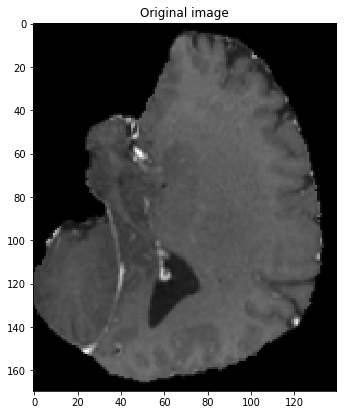

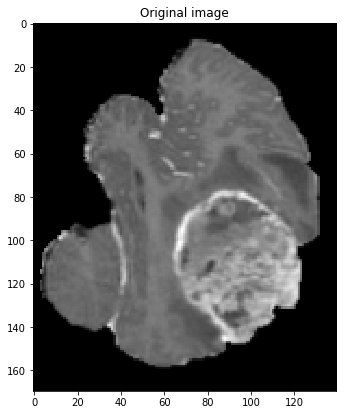

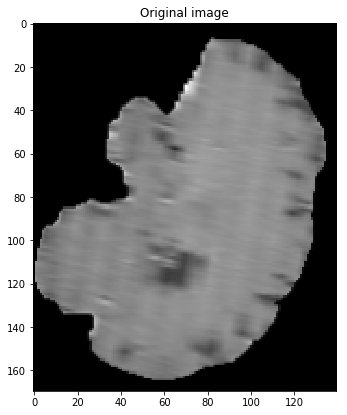

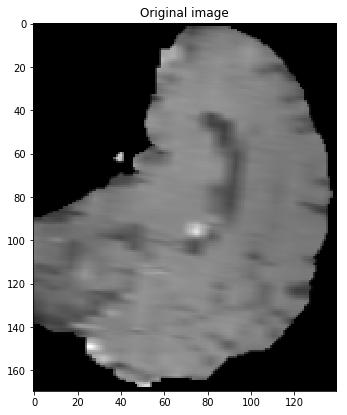

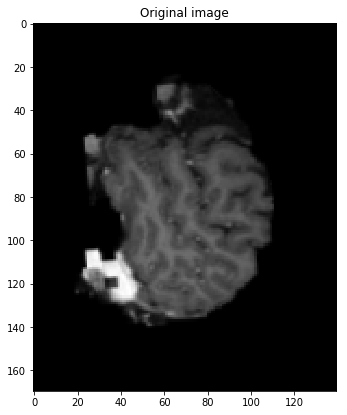

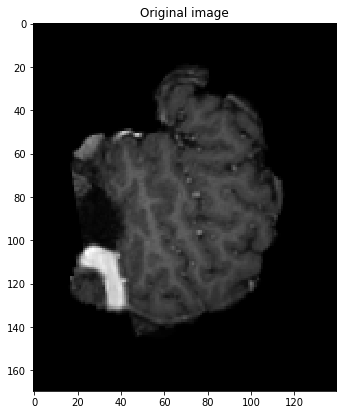

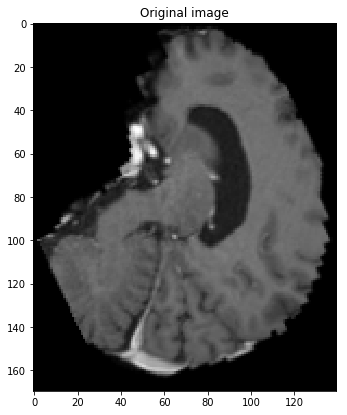

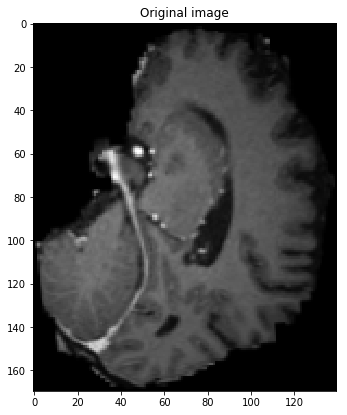

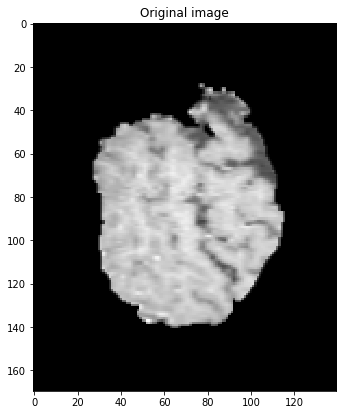

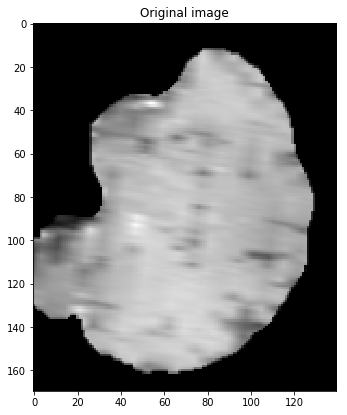

KeyboardInterrupt: 

In [19]:
import matplotlib as mpl
from skimage.transform import rescale, resize
for i, ID in enumerate(val_namespace):
#ID = namespace[400]
    if i > 100:
        continue
    
    if i > 100:
        break

    with open('BRATS_preprocessed_/' + ID, 'rb') as filehandler:
        photo = pickle.load(filehandler)
    
    roi = photo.roi
    roi[roi > -1.0] = 1.0
    roi[roi == -1.0] = 0.0
    label_y = downsample_map(roi, (44,36) ).reshape(1, 44, 36)
    '''
    print(np.max(roi), np.min(roi))
    print(label_y.shape)
    print(photo.mal)
    #with open('Data_original/Original/' + ID, 'rb') as filehandler:
    #    photo = pickle.load(filehandler, encoding = 'latin1')
    
    mm_fs.load_weights('Mass_experiment/experiment_4/model_full_sup_-16-0.21.hdf5')
    pred1 = mm_image.predict(np.repeat(photo.image.reshape(1, 170, 140, 1), 3, axis=3))
    
    eval1 = mm_fs.evaluate(x = np.repeat(photo.image.reshape(1, 170, 140, 1), 3, axis=3),
                           y = label_y)
    print('Maximal pixel value FS: %f'%(np.max(pred1)) )
    print('eval:', eval1)
    
    mm_mil.load_weights('Mass_experiment/experiment_4/FT_epoch_0_dice_0.11885_.hdf5')
    pred2 = mm_image.predict(np.repeat(photo.image.reshape(1, 170, 140, 1), 3, axis=3))
    eval2 = mm_fs.evaluate(x = np.repeat(photo.image.reshape(1, 170, 140, 1), 3, axis=3),
                           y = label_y)
    print('Maximal pixel value FT: %f'%(np.max(pred2)) )
    print('eval:', eval2)
    
    #mm_mil.load_weights('Mass_experiment/experiment_5/FT_epoch_2_dice_0.13794_.hdf5')
    pred3 = mm_image.predict(np.repeat(photo.image.reshape(1, 170, 140, 1), 3, axis=3))
    eval3 = mm_fs.evaluate(x = np.repeat(photo.image.reshape(1, 170, 140, 1), 3, axis=3),
                           y = label_y)
    print('Maximal pixel value FT: %f'%(np.max(pred3)) )
    print('eval:', eval3)
    #mm_fs.load_weights('Mass_experiment/experiment_1/model-15-0.23.hdf5')
    #pred3 = mm_image.predict(np.repeat(photo.image.reshape(1, 170, 140, 1), 3, axis=3))
    
    
    #mm_fs.load_weights('Mass_experiment/experiment_1/model-15-0.23.hdf5')
    #pred4 = mm_image.predict(np.repeat(photo.image.reshape(1, 170, 140, 1), 3, axis=3))
    
    
    #mm_mil.load_weights('coeffs_FS_1/MIL.hdf5')
    #pred5 = mm_image.predict(np.repeat(photo.image.reshape(1, 170, 140, 1), 3, axis=3))
    '''
    plt.figure(figsize=(25,50))
    plt.subplot(1, 4, 1)
    photo.print_image(cmap = 'Reds')
    #photo.print_roi(cmap = 'Reds', linewidths = 3)
    plt.title('Original image')

    #plt.show()
    '''
    photo.image = resize(photo.image, (44,36),
                       anti_aliasing=True)
    
    photo.roi = resize(photo.roi, (44,36),
                       anti_aliasing=True)
    plt.subplot(1, 4, 2)
    photo.print_roi()
    plt.imshow(pred1.reshape((44,36)), cmap = 'Blues')
    #plt.colorbar()
    plt.clim(0, 1)
    plt.title("Fully_Supervised_dice_0.23")
    
    
    plt.subplot(1, 4, 3)
    photo.print_roi()
    plt.imshow(pred2.reshape((44,36)), cmap = 'Blues')
    #plt.colorbar()
    plt.clim(0, 1)
    plt.title("FineTune_dice_0.17")
    
    
    plt.subplot(1, 4, 4)
    photo.print_roi()
    plt.imshow(pred3.reshape((44,36)), cmap = 'Blues')
    #plt.colorbar()
    plt.clim(0, 1)
    plt.title('epoch_25_dice_0.13')
    #plt.title("FS_66_epochs_dice_0.129")
    
    plt.subplot(1, 6, 5)
    photo.print_roi()
    plt.imshow(pred4.reshape((44,36)), cmap = 'Blues')
    #plt.colorbar()
    plt.clim(0, 1)
    plt.title('fineTune_25-1-0.131')
    
    
    plt.subplot(1, 6, 6)
    photo.print_roi()
    plt.imshow(pred5.reshape((44,36)), cmap = 'Blues')
    #plt.colorbar()
    plt.clim(0, 1)
    plt.title('MIL')
    
    
    
    plt.show()
    
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.6, right = 2.4)

    cmap = 'Blues'#mpl.cm.cool
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cb1.set_label('Probability')
    fig.show()
    '''
    plt.show()

In [2]:
mm_mil.summary()

NameError: name 'mm_mil' is not defined

In [ ]:
mm_fs.evaluate_generator(generator=training_generator_fs)

In [ ]:
mm_fs.optimizer.lr.get_value()

In [ ]:
init = tf.global_variables_initializer()
K.set_value(mm_fs.optimizer.lr, 1e-3)

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(mm_fs.optimizer.lr))

In [ ]:
K.get_value(mm_fs.optimizer.lr)

In [ ]:
mm_mil.save_weights('coeffs_FS_1/one.hdf5')
        